# Candidate muon stopping configurations
## Supplemental material for _Covalent charge-neutral muon state in antiferromagnetic MnF<sub>2</sub>_

M. H. Dehn,<sup>1,2,3 </sup> R. Scheuermann,<sup>4</sup> J. K. Shenton,<sup>5,*</sup>  S. J. Blundell,<sup>6</sup> W. A. MacFarlane,<sup>2,3,7</sup> D. Prabhakaran,<sup>6</sup> A. Suter,<sup>4</sup> N. A. Spaldin<sup>5</sup>and R. F. Kiefl<sup>1,2,3,&sect;</sup>


<sup>1</sup>Department of Physics and Astronomy, University of British Columbia, Vancouver, BC V6T 1Z1, Canada    
<sup>2</sup>Stewart Blusson Quantum Matter Institute, University of British Columbia, Vancouver, BC V6T 1Z4, Canada    
<sup>3</sup><span style="font-variant:small-caps;">Triumf</span>, Vancouver, BC V6T 2A3, Canada   
<sup>4</sup>Laboratory for Muon Spectroscopy, Paul Scherrer Institute, Villigen AG, Switzerland    
<sup>5</sup>Department of Materials, ETH Zurich, CH-8093 Zürich, Switzerland   
<sup>6</sup>Oxford University Department of Physics, Clarendon Laboratory, Parks Road, Oxford OX1 3PU, United Kingdom   
<sup>7</sup>Department of Chemistry, University of British Columbia, Vancouver, BC, V6T 1Z1, Canada    
<sup>*</sup> For queries about the supplemental material in this repository contact [J. Kane Shenton](mailto:kane.shenton@stfc.ac.uk).

### Summary

Here we summarise the computed muon hyperfine tensors in all of the fully relaxed configurations in $\mathrm{MnF_{2}}$. These various configurations are described in the paper. The crystal structures for each are provided in the VASP format and can be visualised using, for example the [ASE GUI ](https://wiki.fysik.dtu.dk/ase/ase/gui/gui.htm)or [VESTA](https://jp-minerals.org/vesta/en/).

We also calculate the displacement due to the presence of the muon as a function of distance from the muon (following the minimum image convention throughout). We see that, for each configuration, the perturbation of the ionic positions is large in the vicinity of the muon but that the supercell is sufficiently large such that bulk-like structure is obtained far from the muon site. For example, for the $U\mathrm{_{eff}}=4$ eV structures*, the displacement due to the muon looks like this:

<img src="./candidate_configs/U4_candidate_configs_displacements_due_to_muon.png" width="50%">

*We excluded the Frenkel-like sites for this analysis as the estimates of the displacements in those cases is less straightforward. 


### Computational Details
The following computational setup was used for all of the following calculations:

* DFT code: VASP version 5.4.4
* Plane-wave cutoff energy: 700 eV
* 2x2x2 k-point mesh (corresponding to a 6x6x8 mesh in the primitive cell).
* Exchange-correlation functional: PBEsol
* Hubbard correction (Dudarev scheme) $U\mathrm{_{eff}}=U-J=4$ eV or $2$ eV. See below.
* Maximum force in any structure: 5 meV/Å
* The following PAWs were used:
  * `Mn : PAW_PBE Mn_pv 02Aug2007`
  * `F  : PAW_PBE F 08Apr2002`
  * `H  : PAW_PBE H 15Jun2001`

Further details can be found by inspecting the provided INCAR, KPOINTS, POSCAR or OUTCAR files for each configuration in the subdirectory: `candiate_configs`.

### Setup

In [1]:
import numpy as np
import re
import pandas as pd
# set precision to 3 decimal places
pd.set_option('display.precision', 3)

# ASE
from ase.io import read, write
from ase.visualize import view # optional, for visualization
from ase import Atoms
from ase.geometry import find_mic



# Plotting tools and config.
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('./plots_style.mplstyle')


# add utils.py to path
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import get_hyperfine, get_max_force, extract_freqs, reorder_atoms

%load_ext autoreload
%autoreload 2

In [2]:
charges = ['-1', '0', '1']
sites   = [ '0', '1', '2', 'frenkel' ]
basedir = './candidate_configs'
gamma_mu = 851.616 / (2 * np.pi) # MHz / (2 pi)

In [3]:
def get_displacements(atoms_in:Atoms, atoms_ref_in:Atoms)-> np.ndarray:
    """
    Get the displacement vectors between the atoms in atoms and atoms_ref.
    """
    atoms = atoms_in.copy()
    atoms_ref = atoms_ref_in.copy()
    cell = atoms_ref.cell
    H_idx = [atom.index for atom in atoms if atom.symbol == 'H']
    assert len(H_idx) == 1
    muon_index = H_idx[0]
    # translate the atoms_ref to match the translation of atoms... 
    atoms_ref.translate(cell.T.dot([0.5, 0.5, 0.5]))
    atoms_ref.wrap(eps = 1e-1)
    # add in dummy muon in atoms_ref
    atoms_ref.append(atoms[muon_index])

    # reoder the atoms_ref
    atoms_ref = reorder_atoms(atoms, atoms_ref, check_species=True)
    # get the displacement vectors
    dpos = atoms.positions - atoms_ref.positions
    # get minimum image convention displacement vectors
    dpos, d = find_mic(dpos, atoms_ref.cell)
    if max(d) > 5.0: 
        # raise error if the displacement is too large
        # as this indicates that the atoms are not aligned correctly
        raise ValueError('Displacement is too large')
    return dpos, d

def plot_displacements(dmuon,D, df):
    """
    Plot the displacements due to the muon
    as a function of distance from the muon. 

    Args:   
        dmuon: distances from the muon 
        D:     norm of displacements  due to the muon
        df:    dataframe with site labels etc.
    """
    order =  np.argsort(dmuon, axis=1)
    fig, ax = plt.subplots()
    colors = ['C0', 'C1', 'C2']
    markers = ['o','s', '^']
    ax.axhspan(0, 0.1, color='lightblue', alpha=0.2)
    # skip the Frenkel sites
    non_frenkel_idx = df[df['site'] != 'frenkel'].index
    for idx in non_frenkel_idx:
        x = dmuon[idx][order[idx]]
        y = D[idx][order[idx]]
        site = int(df.loc[idx, 'site'])
        charge = int(df.loc[idx, 'charge'])
        ax.scatter(x,y,
                    color=colors[charge],
                    marker=markers[site],
                    s=12,
                    label=f'Mu$^{{{charge}}}_{{{site}}}$',
                    alpha=0.8,
                    edgecolors ='none')
    ax.set_xlabel('Distance from Muon (Å)')
    ax.set_ylabel('Displacement due to Muon (Å)')
    ax.set_xlim([0,13])
    ax.legend(ncol=3)
    return fig, ax
    


### U<sub>eff</sub> = 4 eV configurations 
#### Read in results

In [4]:

results = []
images  = []
for charge in charges:
    # new dataframe for each charge
    for site in sites:
        # read in the OUTCAR file
        outcar_path = f'{basedir}/charge_{charge}/site-{site}/OUTCAR'
        atoms = read(outcar_path)
        # index of the H atom
        H_idx = [atom.index for atom in atoms if atom.symbol == 'H'][0]
        # total energy of the system
        e = atoms.get_total_energy()
        # max force
        max_force = get_max_force(atoms) * 1e3 # convert to meV/A
        # get the hyperfine tensor
        iso, dip, total = extract_freqs(outcar_path, natoms=len(atoms), chosen_atom=H_idx, gamma = gamma_mu)
        # add to dataframe
        results.append({
                'charge': charge,
                'site': site,
                'Total Energy (eV)': e,
                'Max Force (meV/A)': max_force,
                'Isotropic freq. (MHz)': iso,
                'Dipolar freq. (MHz)': dip,
                'Total freq. (MHz)': total,
                'path': outcar_path}
        )
        images.append(atoms)
# make a dataframe to hold the results
df = pd.DataFrame(results)
# save to csv
df.to_csv(f'{basedir}/U4_candidate_configs.csv')
df


,charge,site,Total Energy (eV),Max Force (meV/A),Isotropic freq. (MHz),Dipolar freq. (MHz),Total freq. (MHz),path
0,-1,0,-1405.729,3.468,5.625,47.032,52.657,./candidate_configs/charge_-1/site-0/OUTCAR
1,-1,1,-1408.275,4.267,14.299,-178.031,-163.731,./candidate_configs/charge_-1/site-1/OUTCAR
2,-1,2,-1408.162,4.729,35.986,-238.955,-202.970,./candidate_configs/charge_-1/site-2/OUTCAR
3,-1,frenkel,-1408.294,3.085,-28.237,205.522,177.285,./candidate_configs/charge_-1/site-frenkel/OUTCAR
4,0,0,-1410.953,4.612,1976.631,67.227,2043.859,./candidate_configs/charge_0/site-0/OUTCAR
5,0,1,-1411.138,4.603,1568.614,111.335,1679.938,./candidate_configs/charge_0/site-1/OUTCAR
6,0,2,-1411.035,3.021,-1416.788,-142.451,-1559.239,./candidate_configs/charge_0/site-2/OUTCAR
7,0,frenkel,-1409.780,4.582,-736.496,264.956,-471.540,./candidate_configs/charge_0/site-frenkel/OUTCAR
8,1,0,-1415.632,4.292,5.015,47.371,52.386,./candidate_configs/charge_1/site-0/OUTCAR
9,1,1,-1414.515,4.647,35.443,-328.343,-292.900,./candidate_configs/charge_1/site-1/OUTCAR


In [5]:
# for visualization it helps to move the muons to the centre of the cell
for atoms in images:
    atoms.translate(atoms.cell.T.dot([0.5, 0.5, 0.5]))
    atoms.wrap(eps=1e-1)

In [6]:
# We can compare our relaxed defect structures to the pristine structure:
xc = 'pbesol'
U_Mn = 4
pristine_mnf2 = read(f'./hubbard_u_test/{xc}/Ueff_Mn-{U_Mn}/scf/POSCAR')
pristine_mnf2_sc334 = pristine_mnf2 * (3,3,4)


# Get the displacement vectors between the pristine and relaxed defect structures
# Ignore the Frenkel ones for now as the interstitial F messes up the estimate... 
non_frenkel_idx = df[df['site'] != 'frenkel'].index
for i in range(len(images)):
    natoms = len(images[i])
    if i in non_frenkel_idx:
        # get the displacement vectors
        dpos, d = get_displacements(images[i], pristine_mnf2_sc334)
    else:
        dpos = np.zeros((natoms, 3))
        d = np.zeros(natoms)
    # store in images
    images[i].set_velocities(dpos)
    images[i].set_array('d', d)


Now we've added the displacements due to the muon in as 'velocities' we can easily visualise them with the ASE GUI.

Note that you can color by 'velocities' or Ctrl-G to draw 'velocity' arrows.  

In [7]:
view(images)

# or you can view just the closest 50 atoms:
# d = [atoms.get_distances(-1, range(len(atoms)), mic=True) for atoms in images]
# closest_idx = [np.argsort(di)[:51] for di in d]
# view([atoms[list(idx) + [-1]] for idx, atoms in zip(closest_idx, images)])

<Popen: returncode: None args: ['/home/jks/miniconda3/envs/mnf2_paper/bin/py...>

Plot the displacements as a function of distance from the muon:


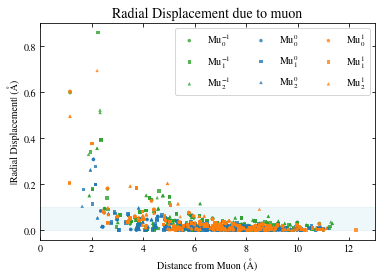

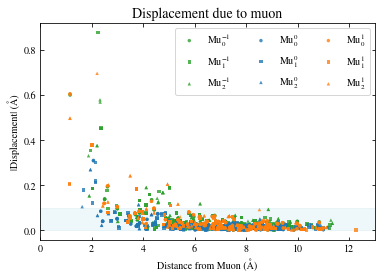

In [8]:
# displacement vectors from pristine structure
v = np.array([atom.get_velocities()[:-1] for atom in images])
# total displacement
D = np.linalg.norm(v, axis=2)
# vector from muon to atom
rmuon = np.array([atoms.get_distances(H_idx, range(len(atoms)-1), mic=True, vector=True) for atoms in images])
# distances from muon to atom
dmuon = np.linalg.norm(rmuon, axis=2)

# radial displacement of the muon
#  - project the displacement vector onto the muon-atom unit vector
# normalize the displacement vectors
rmuon /= np.linalg.norm(rmuon, axis=2)[:,:,None]
rad_d = np.array([np.sum(vi*rmuoni, axis=1) for vi, rmuoni in zip(v, rmuon)])
rad_d = np.abs(rad_d)
fig, ax = plot_displacements(dmuon,rad_d, df)
ax.set_ylabel('|Radial Displacement| (Å)')
ax.set_title('Radial Displacement due to muon')
# fig.savefig(f'{basedir}/U4_candidate_configs_radial_displacement_due_to_muon.png', dpi=300)
# fig.savefig(f'{basedir}/U4_candidate_configs_radial_displacement_due_to_muon.pdf')

# Plot the actual displacement magnitude as a function of the distance from the muon
fig, ax = plot_displacements(dmuon,D, df)
ax.set_title('Displacement due to muon')
ax.set_ylabel('|Displacement| (Å)')
# fig.savefig(f'{basedir}/U4_candidate_configs_displacements_due_to_muon.png', dpi=300)
# fig.savefig(f'{basedir}/U4_candidate_configs_displacements_due_to_muon.pdf')

### U<sub>eff</sub> = 2 eV configurations

For a subset of the above sites, we re-ran the structures using a $U\mathrm{_{eff}} = 2$ eV. 

The unit cell was first scaled to that corresponding to pristine $\mathrm{MnF}_2$ at $U\mathrm{_{eff}} = 2$ eV. Then the atomic coordinates were fully relaxed before the hyperfine tensors were computed. 

#### Read in results

In [9]:
u2_dirs = ['charge_-1/site-1/U2',
          'charge_-1/site-frenkel/U2',
          'charge_0/site-0/U2',
          'charge_0/site-1/U2',
          'charge_1/site-0/U2']
u2_results = []
u2_images  = []
for d in u2_dirs:
    charge, site = d.split('/')[:2]
    outcar_path = f'{basedir}/{d}/OUTCAR'
    atoms = read(outcar_path)    # index of the H atom
    H_idx = [atom.index for atom in atoms if atom.symbol == 'H'][0]
    # total energy of the system
    e = atoms.get_total_energy()
    # max force
    max_force = get_max_force(atoms) * 1e3 # convert to meV/A
    # get the hyperfine tensor
    iso, dip, total = extract_freqs(outcar_path, len(atoms), H_idx, gamma=gamma_mu)
    # add to dataframe
    u2_results.append({
                'charge': charge.split('_')[-1],
                'site': site.split('-')[-1],
                'Total Energy (eV)': e,
                'Max Force (meV/A)': max_force,
                'Isotropic freq. (MHz)': iso,
                'Dipolar freq. (MHz)': dip,
                'Total freq. (MHz)': total,
                'path': outcar_path}
    )
    u2_images.append(atoms)
# make a dataframe to hold the results
df_u2 = pd.DataFrame(u2_results)
# save to csv
df_u2.to_csv(f'{basedir}/U2_candidate_configs.csv')
df_u2
    

,charge,site,Total Energy (eV),Max Force (meV/A),Isotropic freq. (MHz),Dipolar freq. (MHz),Total freq. (MHz),path
0,-1,1,-1434.963,4.636,4.766,-189.438,-184.672,./candidate_configs/charge_-1/site-1/U2/OUTCAR
1,-1,frenkel,-1434.970,3.970,-22.432,209.475,187.044,./candidate_configs/charge_-1/site-frenkel/U2/...
2,0,0,-1437.650,4.641,1636.248,91.331,1727.579,./candidate_configs/charge_0/site-0/U2/OUTCAR
3,0,1,-1438.013,4.837,1159.196,122.664,1281.859,./candidate_configs/charge_0/site-1/U2/OUTCAR
4,1,0,-1442.320,4.262,5.896,46.896,52.792,./candidate_configs/charge_1/site-0/U2/OUTCAR


In [10]:
# for visualization it helps to move the muons to the centre of the cell
for atoms in u2_images:
    atoms.translate(atoms.cell.T.dot([0.5, 0.5, 0.5]))
    atoms.wrap(eps=1e-1)

In [11]:
# For U=2 eV, we need to make sure we take the correct reference pristine structure
xc = 'pbesol'
U_Mn = 2
pristine_mnf2_u2 = read(f'./hubbard_u_test/{xc}/Ueff_Mn-{U_Mn}/scf/POSCAR')
pristine_mnf2_u2_sc334 = pristine_mnf2_u2 * (3,3,4)

# Get the displacement vectors between the pristine and relaxed defect structures
# Ignore the Frenkel ones for now as the interstitial F messes up the estimate... 
non_frenkel_idx = df_u2[df_u2['site'] != 'frenkel'].index
for i in range(len(u2_images)):
    natoms = len(u2_images[i])
    if i in non_frenkel_idx:
        # get the displacement vectors
        dpos, d = get_displacements(u2_images[i], pristine_mnf2_u2_sc334)
    else:
        dpos = np.zeros((natoms, 3))
        d = np.zeros(natoms)
    # store in u2_images
    u2_images[i].set_velocities(dpos)
    u2_images[i].set_array('d', d)

Now we've added the displacements due to the muon in as 'velocities' we can easily visualise them with the ASE GUI.

Note that you can color by 'velocities' or Ctrl-G to draw 'velocity' arrows.  

In [12]:
view(u2_images)

## or you can view just the closest 50 atoms:
# d = [atoms.get_distances(-1, range(len(atoms)), mic=True) for atoms in u2_images]
# closest_idx = [np.argsort(di)[:51] for di in d]
# view([atoms[list(idx) + [-1]] for idx, atoms in zip(closest_idx, u2_images)])


<Popen: returncode: None args: ['/home/jks/miniconda3/envs/mnf2_paper/bin/py...>

We can also plot the displacement from the pristine structure, as a function of distance from the muon:

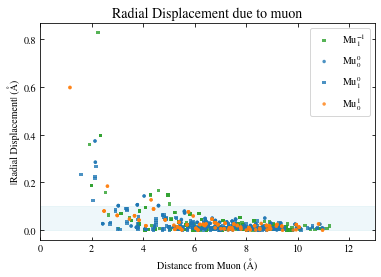

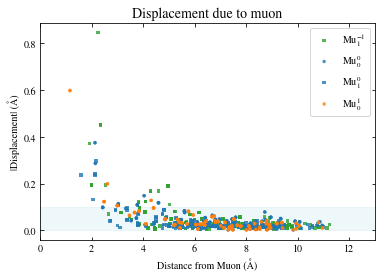

In [13]:
# displacement vectors from pristine structure
v = np.array([atom.get_velocities()[:-1] for atom in u2_images])
# total displacement
D = np.linalg.norm(v, axis=2)
# vector from muon to atom
rmuon = np.array([atoms.get_distances(H_idx, range(len(atoms)-1), mic=True, vector=True) for atoms in u2_images])
# distances from muon to atom
dmuon = np.linalg.norm(rmuon, axis=2)

# radial displacement of the muon
#  - project the displacement vector onto the muon-atom unit vector
# normalize the displacement vectors
rmuon /= np.linalg.norm(rmuon, axis=2)[:,:,None]
rad_d = np.array([np.sum(vi*rmuoni, axis=1) for vi, rmuoni in zip(v, rmuon)])
rad_d = np.abs(rad_d)
fig, ax = plot_displacements(dmuon,rad_d, df_u2)
ax.set_ylabel('|Radial Displacement| (Å)')
ax.set_title('Radial Displacement due to muon')
ax.legend(ncol=1)
fig.savefig(f'{basedir}/U2_candidate_configs_radial_displacement_due_to_muon.pdf')

# Plot the actual displacement magnitude as a function of the distance from the muon
fig, ax = plot_displacements(dmuon,D, df_u2)
ax.set_title('Displacement due to muon')
ax.set_ylabel('|Displacement| (Å)')
ax.legend(ncol=1)
# fig.savefig(f'{basedir}/U2_candidate_configs_displacements_due_to_muon.pdf')